In [1]:
import os, sys
from pathlib import Path

project_root = Path().resolve().parents[1]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
from datetime import timedelta
import dv_processing as dv
from torchvision import transforms
import src.data.events_encoding as ev_enc
import matplotlib.pyplot as plt
import torch


In [3]:
normalize_param = {
    'accumulate': (0.5, 0.01),
    'time_surface': (0.0, 0.03),
    'custom': (0.0, 0.003)
}

In [4]:
def dv_data_frame_tSlice(file_path, duration=10, encoding_type='accumulate' ):
    """
    Extract frames from a .aedat4 file using a time slice.
    Args:
        file_path: str
        duration (milliseconds): int
        press_times_list: list of time (every 2 elements are a pair of start time and end time)
        encoding_type: str ('accumulate', 'time_surface', 'custom')
    Returns:
        list[np.ndarray]: frames (each of shape (H, W))
        list[int]: labels (0 for no press and 1 for press)
    """
    capture = dv.io.MonoCameraRecording(file_path)
    
    frames = []

    if not capture.isEventStreamAvailable():
        raise RuntimeError("Input camera does not provide an event stream.")

    slicer = dv.EventStreamSlicer()
    if encoding_type == 'accumulate':
        encoding_func = ev_enc.accumulate_dv_encode
    elif encoding_type == 'time_surface':
        encoding_func = ev_enc.timesurface_dv_encode
    elif encoding_type == 'custom':
        encoding_func = ev_enc.custom_encode

    def slicing_callback(events: dv.EventStore):
        frame = encoding_func(events, capture.getEventResolution())
        frames.append(frame)

    slicer.doEveryTimeInterval(timedelta(milliseconds=duration), slicing_callback)

    while capture.isRunning():
        events = capture.getNextEventBatch()
        if events is not None:
            slicer.accept(events)
    return frames

In [ ]:
frame = dv_data_frame_tSlice(r'D:\UET\SNN\Visual-Tactile-Sensing-with-Event-Cameras-using-Spiking-Neural-Networks\data\raw_data\raw1.aedat4', duration=10, encoding_type='accumulate')


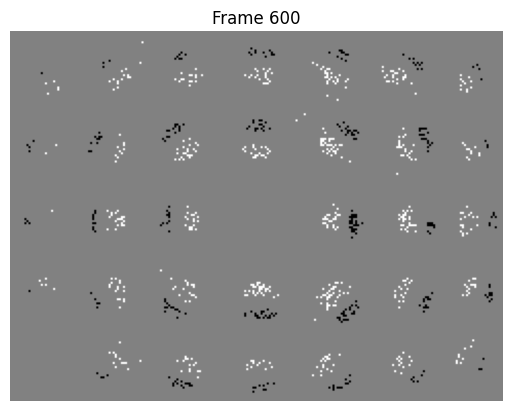

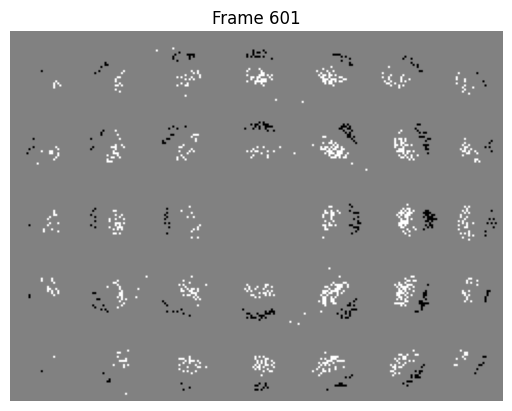

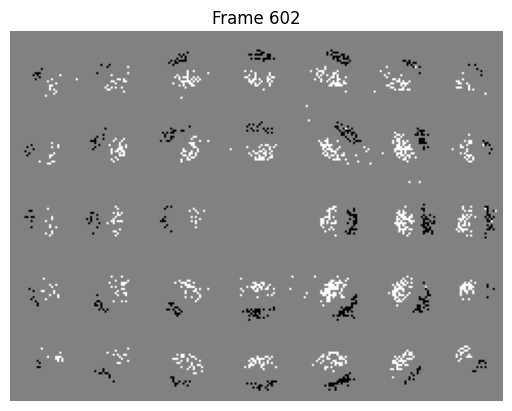

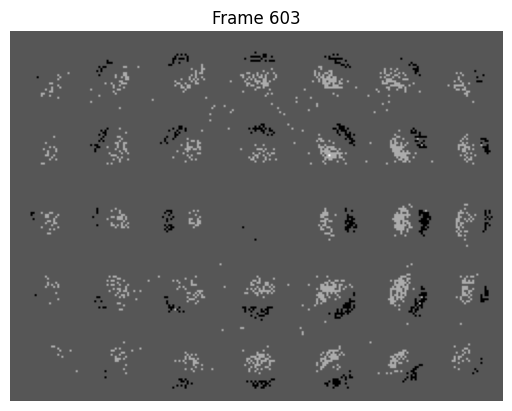

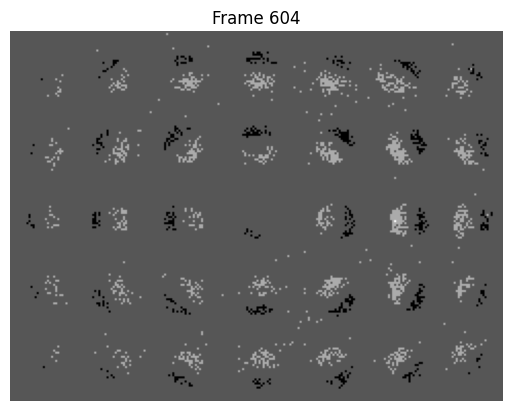

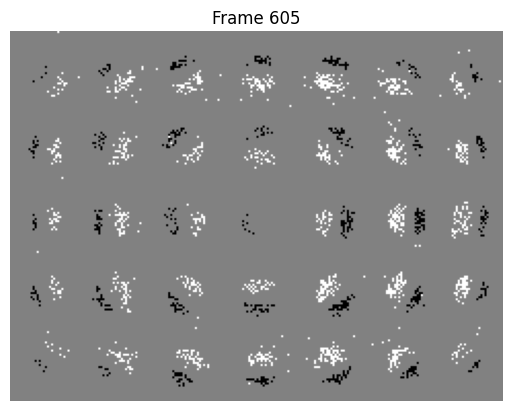

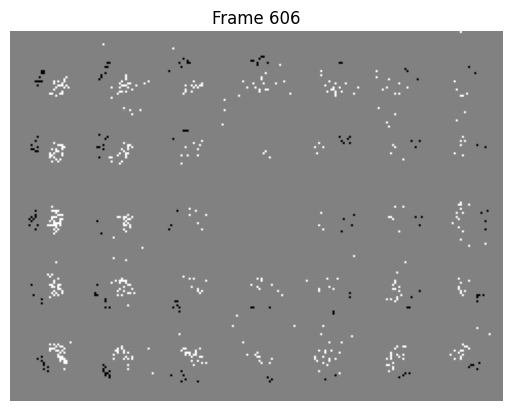

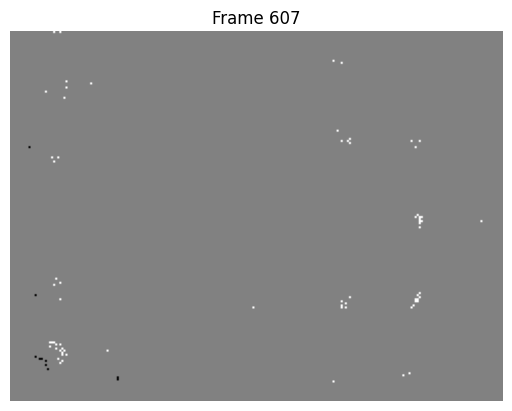

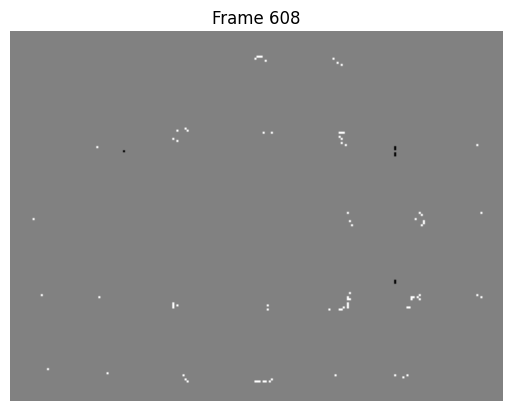

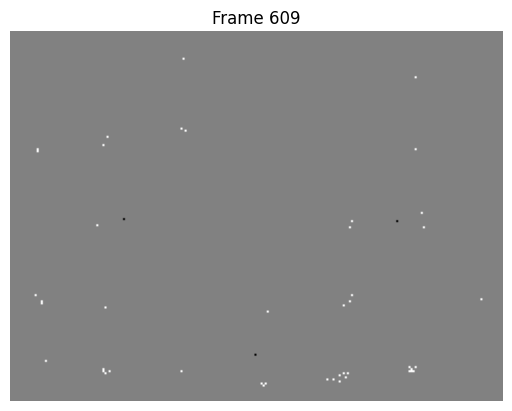

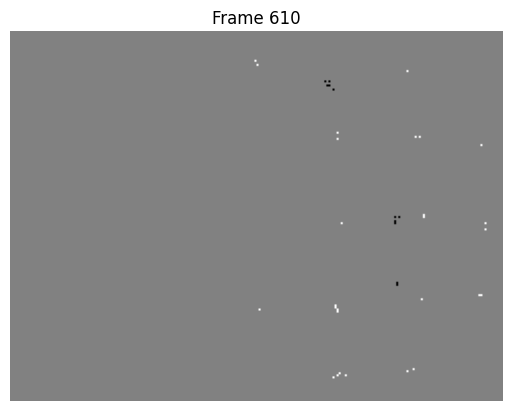

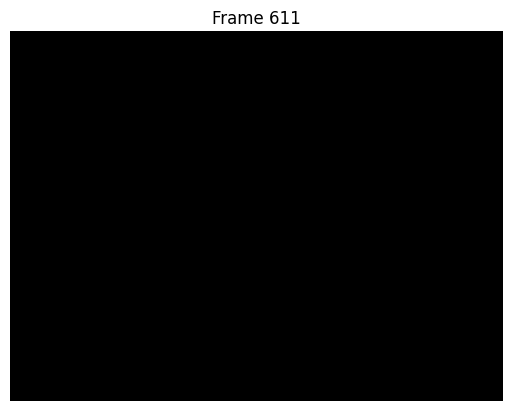

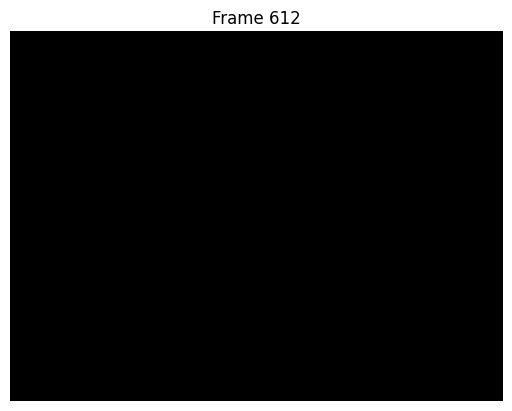

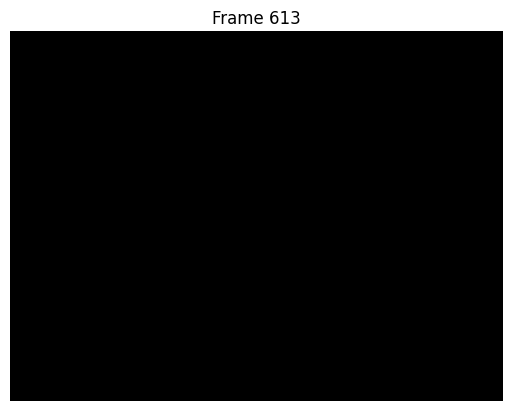

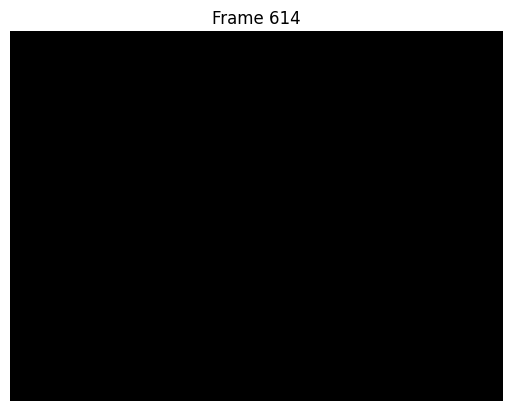

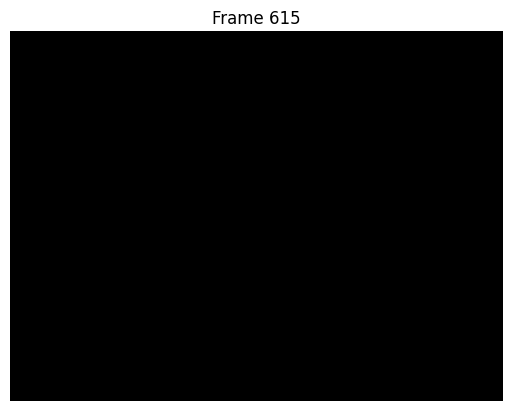

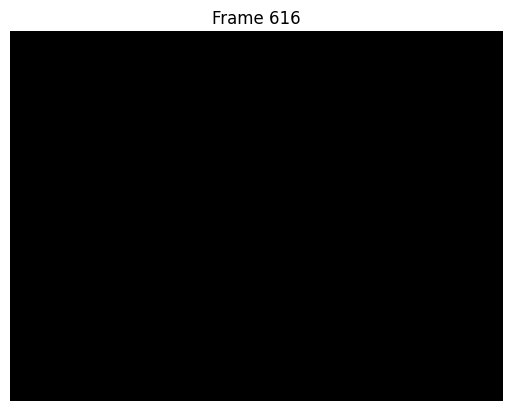

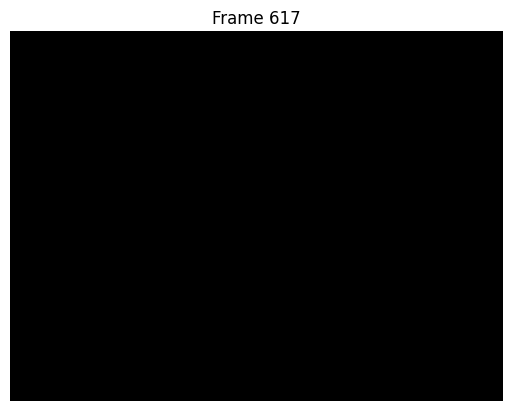

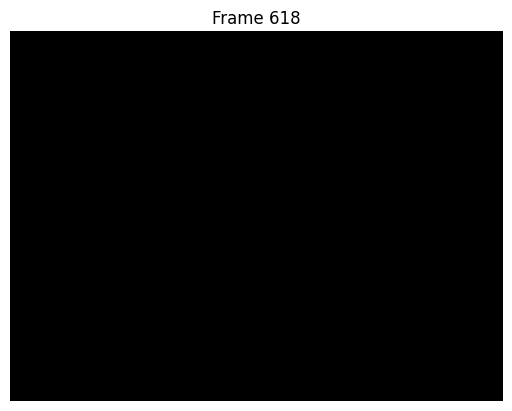

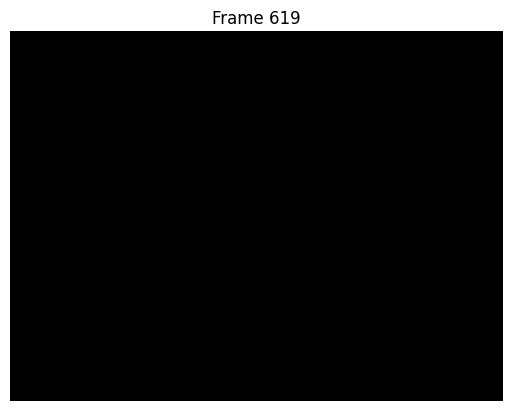

In [15]:
# plot the first 10 frames
for i in range(600,620):
    plt.imshow(frame[i], cmap='gray')
    plt.title(f'Frame {i}')
    plt.axis('off')
    plt.show()
    plt.pause(0.1)

In [12]:
def preprocess_frames(frames, encoding_type='accumulate', target_size=(32, 32)):
    mean, std = normalize_param[encoding_type]

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),  # Resize the images if needed
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),         # Convert images to tensor
        transforms.Normalize(mean=mean, std=std),  # Normalize
    ])

    class SplitChannelsTransform:
        def __call__(self, img):
            # Split d channels into list of (H, W) tensors
            return [img[i] for i in range(img.shape[0])]

    class MergeChannelsTransform:
        def __call__(self, imgs):
            return torch.stack(imgs).squeeze()  # Merge list of (H, W) tensors into (d, H, W)

    custom_transform = transforms.Compose([
        SplitChannelsTransform(),  # Split into d channels
        transforms.Lambda(lambda imgs: [transforms.ToPILImage()(img) for img in imgs]),  # Convert to PIL
        transforms.Lambda(lambda imgs: [transforms.Resize(target_size)(img) for img in imgs]),  # Resize
        transforms.Lambda(lambda imgs: [transforms.ToTensor()(img) for img in imgs]),  # Convert to tensor (1, H, W)
        transforms.Lambda(lambda imgs: [transforms.Normalize(mean=0, std=1)(img) for i, img in enumerate(imgs)]),  # Normalize per channel
        MergeChannelsTransform()  # Merge back to (d, H, W)
    ])

    if encoding_type == 'custom':
        return [custom_transform(frame) for frame in frames]

    return [transform(frame) for frame in frames]

In [ ]:
def visualize_encoded_frames(encoding_type='accumulate'):
    frame = dv_data_frame_tSlice(r'D:\UET\SNN\Visual-Tactile-Sensing-with-Event-Cameras-using-Spiking-Neural-Networks\data\raw_data\raw1.aedat4', duration=10, encoding_type=encoding_type)
    preprocessed_frames = preprocess_frames(frame, encoding_type=encoding_type, target_size=(32, 32))
    plt.imshow(preprocessed_frames[602].cpu().squeeze(0), cmap='gray')  
    plt.axis('off')
    plt.title(f"{encoding_type.capitalize().replace('_', ' ')} Encoding")
    plt.savefig(f'{encoding_type}_encoding.png', dpi=300, bbox_inches='tight')
    plt.show()

## Accumulate Encoding

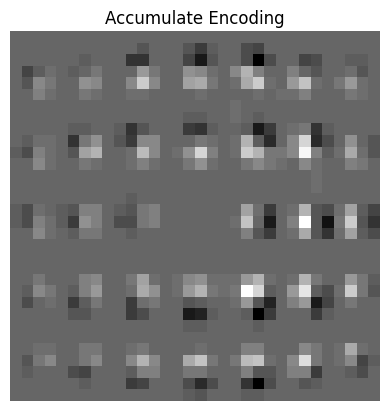

In [32]:
visualize_encoded_frames('accumulate')

## Time surface Encoding

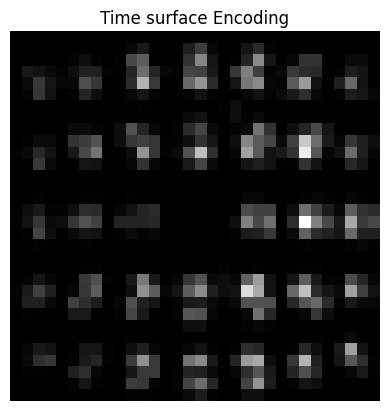

In [33]:
visualize_encoded_frames('time_surface')

## Sinusiodal Encoding

In [8]:
frame = dv_data_frame_tSlice(r'D:\UET\SNN\Visual-Tactile-Sensing-with-Event-Cameras-using-Spiking-Neural-Networks\data\raw_data\raw1.aedat4', duration=10, encoding_type='custom')

In [9]:
preprocessed_frames = preprocess_frames(frame, encoding_type='custom', target_size=(32, 32))


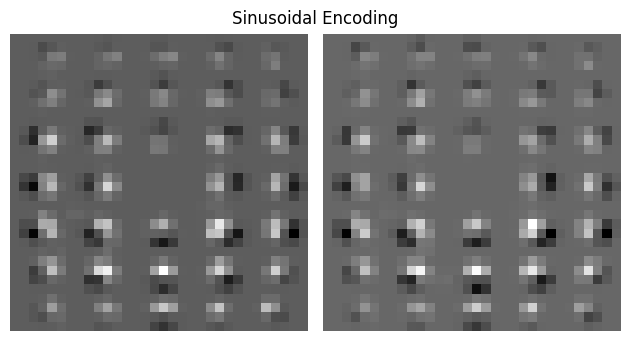

In [10]:
tensor = preprocessed_frames[602].cpu().squeeze(0)  # shape [2,32,32]
ch0, ch1 = tensor[0], tensor[1]

# Tạo 2 subplots
fig, axes = plt.subplots(1, 2)

# Vẽ ảnh
axes[0].imshow(ch0, cmap='gray')
axes[0].axis('off')
axes[1].imshow(ch1, cmap='gray')
axes[1].axis('off')

# Điều chỉnh để có khoảng trống cho suptitle
plt.tight_layout(rect=[0, 0, 1, 1])

# Đặt tiêu đề chính (suptitle) chính giữa phía trên figure
fig.suptitle('Sinusoidal Encoding', y=0.86)
plt.savefig('sinusoidal_encoding.png', dpi=300, bbox_inches='tight')
plt.show()